## DV2599 Project
Group 8


***
Viktor Fransson

vifr22@student.bth.se

***

Tobias Gustafsson

togu22@student.bth.se
***

#### Initialize

In [50]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, f1_score, precision_score
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load dataset
df = pd.read_csv('playground-series-s4e11/train.csv')


#### Data Munging

In [51]:
# alternatives = {}
# for instance in df['Degree']:
#     if instance in alternatives:
#         alternatives[instance] += 1
#     else:
#         alternatives[instance] = 1
# print(alternatives)

# weird entries:
# Degree: 0, 29, 5.61, 5.56, B.03, 7.06, 24, 8.56, 5.88, B.3.79
# Dietary Habits: Yes, Pratham, BSc, Gender, 3, More Healthy, Less than Healthy, Mihir, 1.0, Hormonal, Electrician, No Healthy, Less Healthy, M.Tech, Vegas, No, Male, Indoor, Class 12, 2
# Profession: Moderate
# City: 3.0, Less than 5 Kalyan, No
# Sleep Duration: 40-45 hours, Moderate, 55-66 hours, Indore, 45, 35-36 hours, No, than 5 hours, 49 hours, Unhealthy, Work_Study_Hours, 45-48 hours, Pune
# 

# Copy of df to change
df_munged = df.copy()

# Drops
df_munged = df_munged.drop(['id', 'City', 'Name', 'Profession', 'Degree'], axis=1)

# Gender
df_munged['Gender'] = df_munged['Gender'].replace('Female', 1).replace('Male', 0)

# Dietary habits, straightforward conversion to numbers Healthy = 2, Moderate = 1, Unhealthy = 0
values = [0, 1, 2]
df_munged['Dietary Habits'] = df_munged['Dietary Habits'].replace('Healthy', 2).replace('Moderate', 1).replace('Unhealthy', 0)
df_munged['Dietary Habits'] = df_munged['Dietary Habits'].where(df_munged['Dietary Habits'].isin(values), other=np.nan)
df_munged['Dietary Habits'] = df_munged['Dietary Habits'].astype('category')
df_munged['Dietary Habits'] = df_munged['Dietary Habits'].cat.codes

# Sleep duration
values = [0, 1, 2, 3]
df_munged['Sleep Duration'] = df_munged['Sleep Duration'].replace('More than 8 hours', 3).replace('7-8 hours', 2).replace('5-6 hours', 1).replace('Less than 5 hours', 0)
df_munged['Sleep Duration'] = df_munged['Sleep Duration'].where(df_munged['Sleep Duration'].isin(values), other=np.nan)
df_munged['Sleep Duration'] = df_munged['Sleep Duration'].astype('category')
df_munged['Sleep Duration'] = df_munged['Sleep Duration'].cat.codes

# Have you ever had suicidal thoughts ?
df_munged['Have you ever had suicidal thoughts ?'] = df_munged['Have you ever had suicidal thoughts ?'].replace('Yes', 1).replace('No', 0)

# Family History of Mental Illness
df_munged['Family History of Mental Illness'] = df_munged['Family History of Mental Illness'].replace('Yes', 1).replace('No', 0)

# Working Professional or Student
df_munged['Working Professional or Student'] = df_munged['Working Professional or Student'].replace('Working Professional', 1).replace('Student', 0)



# Split dataset
x_xg = df_munged.drop('Depression', axis=1)
y_xg = df_munged['Depression']

x = df.drop(['id', 'Name', 'Depression'], axis=1)
y = df['Depression']

# df['CGPA'] = pd.to_numeric(df['CGPA'], errors='coerce').fillna(0).round().astype(int)

display(x_xg.dtypes)


Gender                                     int64
Age                                      float64
Working Professional or Student            int64
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                              int8
Dietary Habits                              int8
Have you ever had suicidal thoughts ?      int64
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness           int64
dtype: object

#### Big Data Analysisis

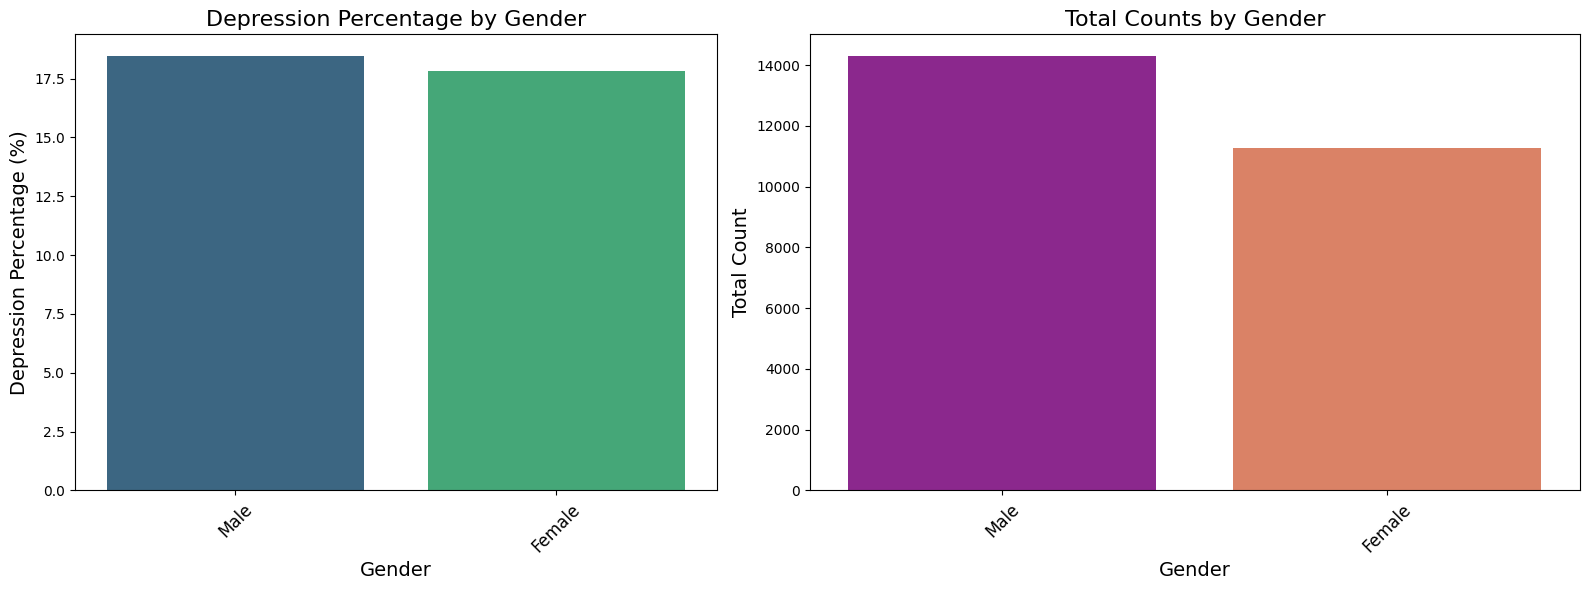

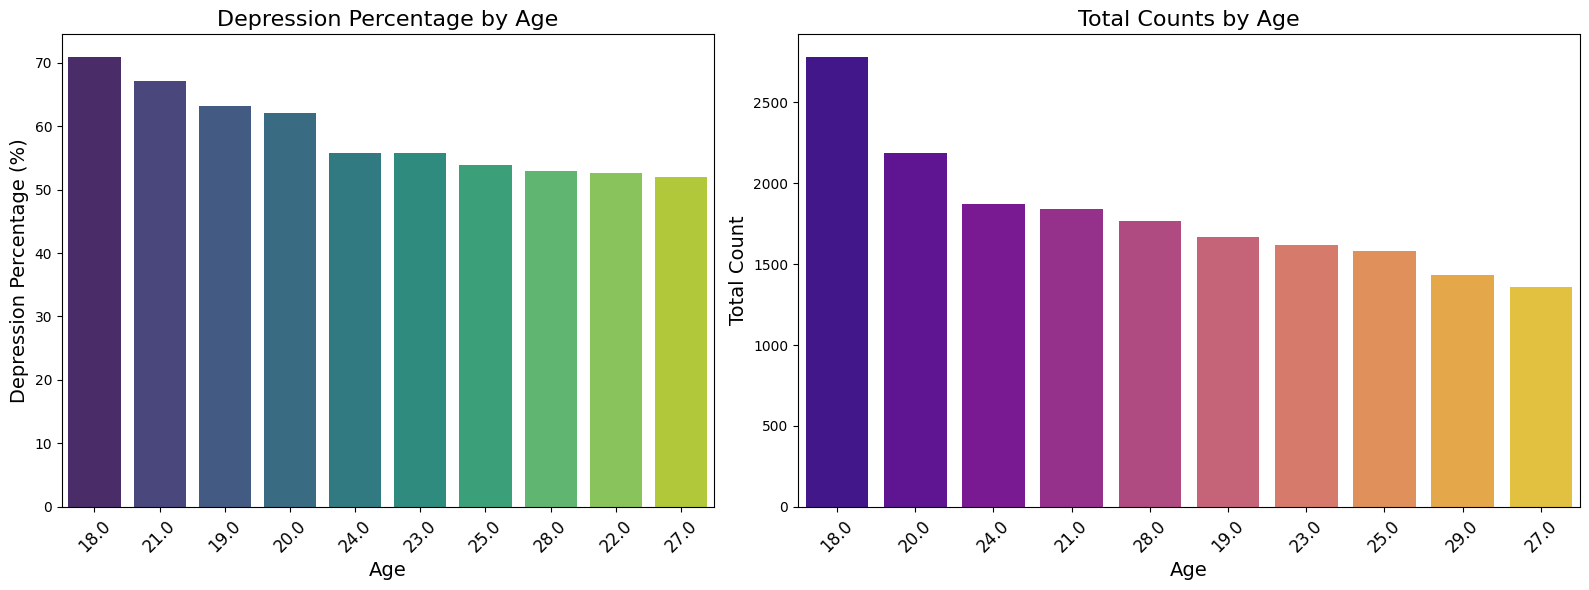

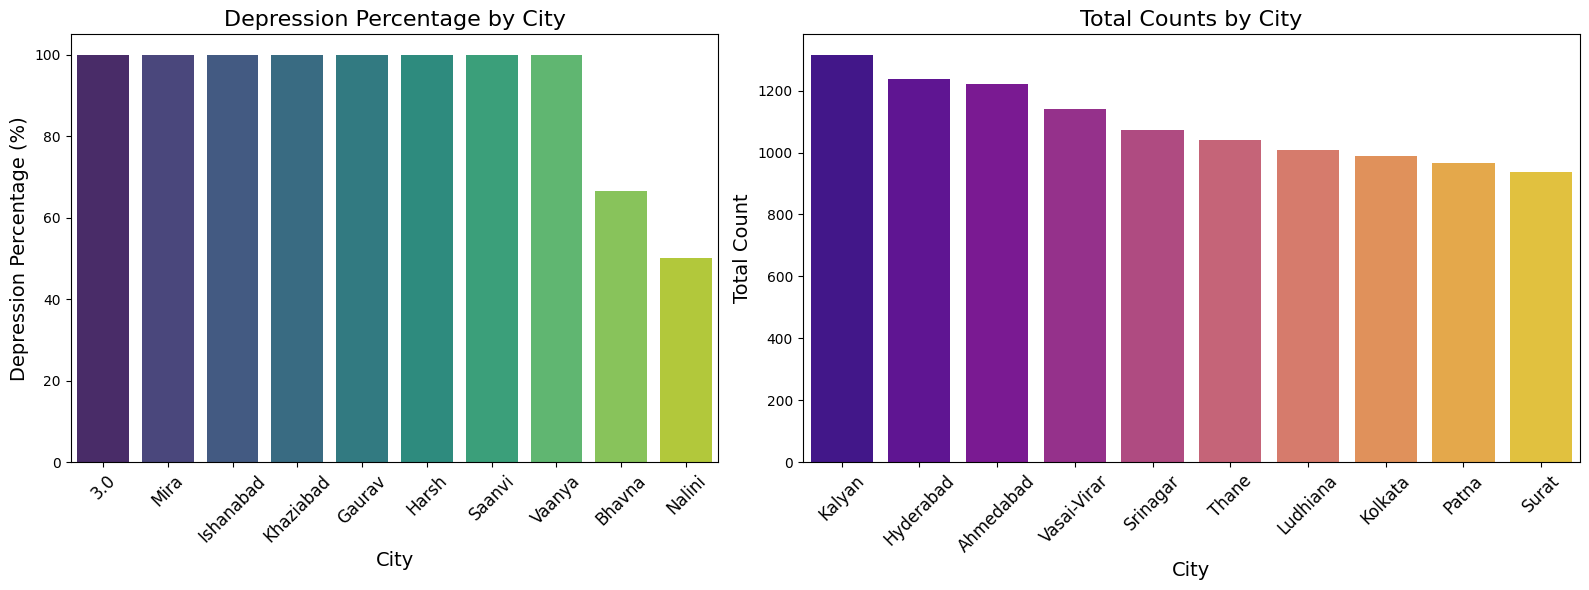

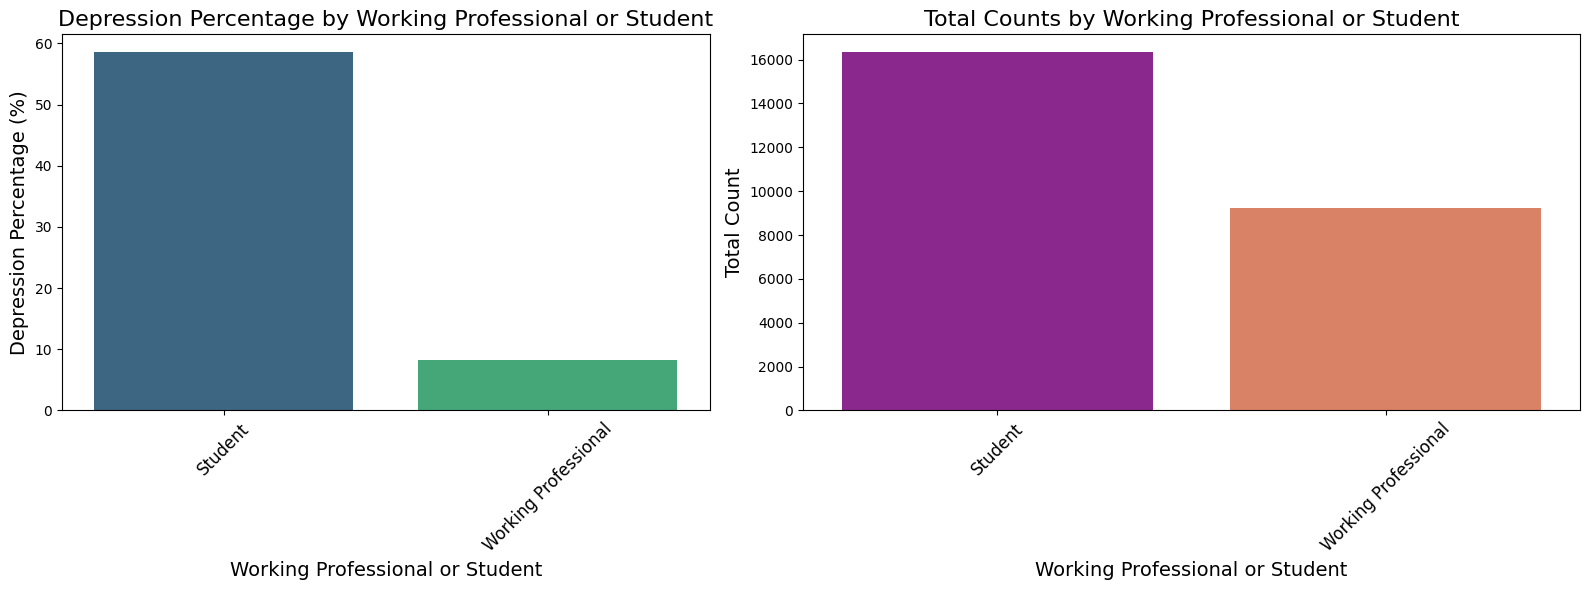

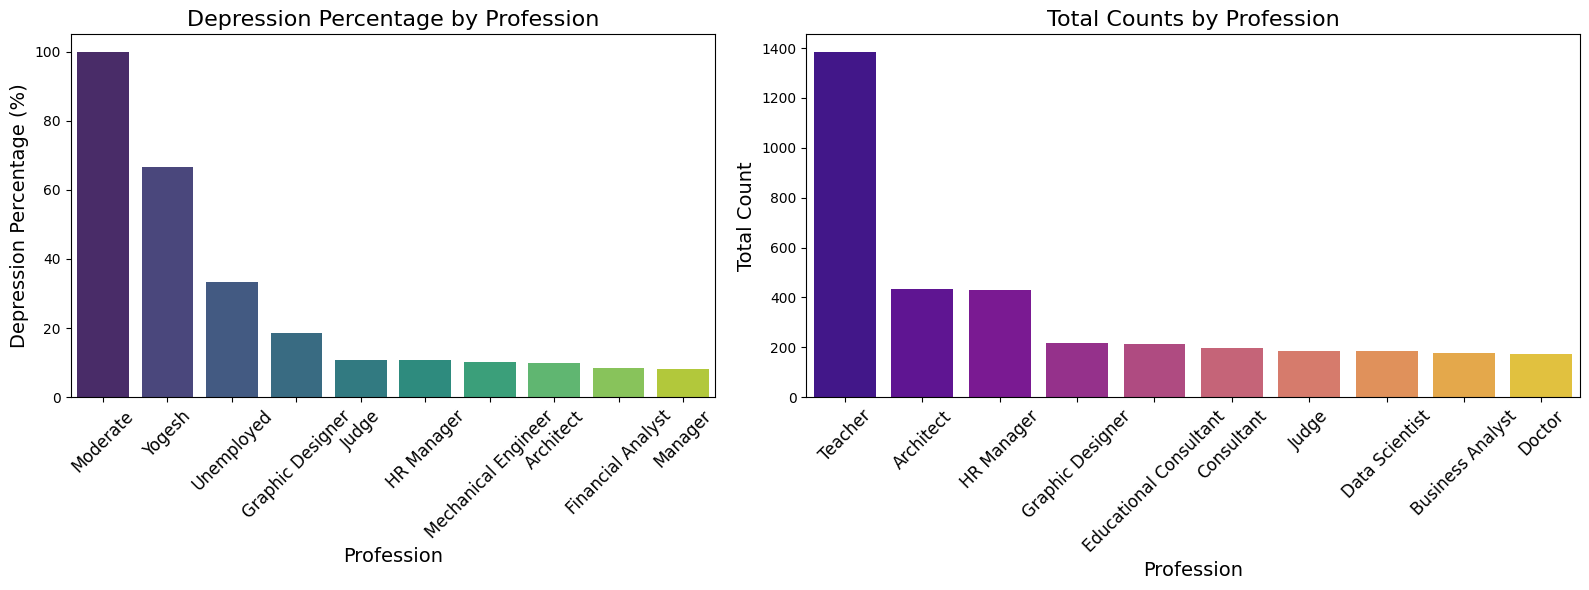

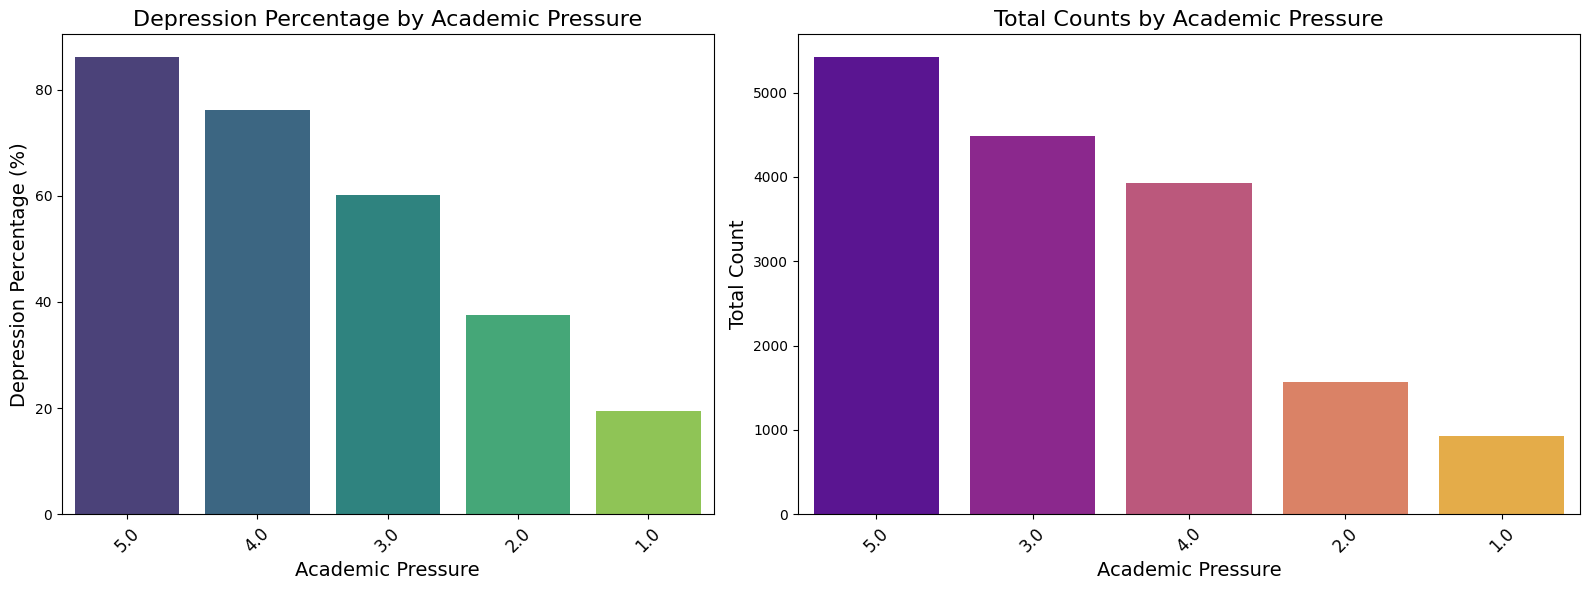

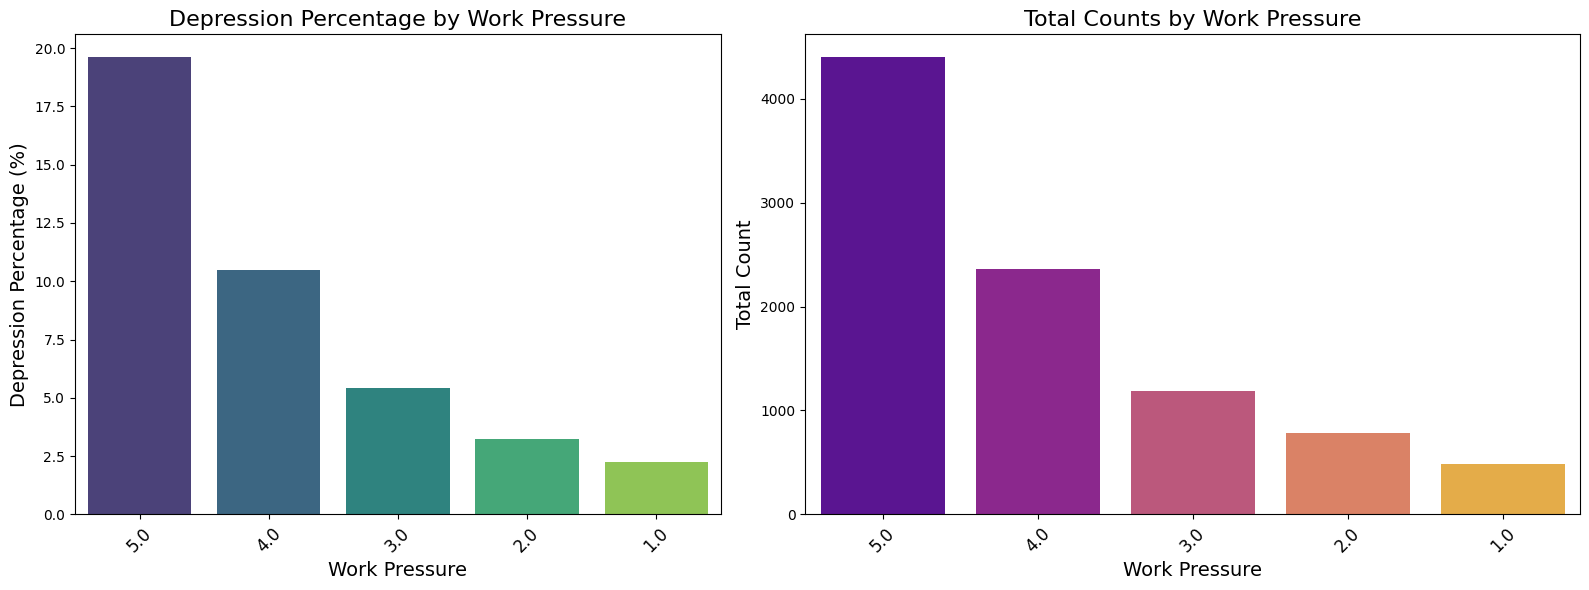

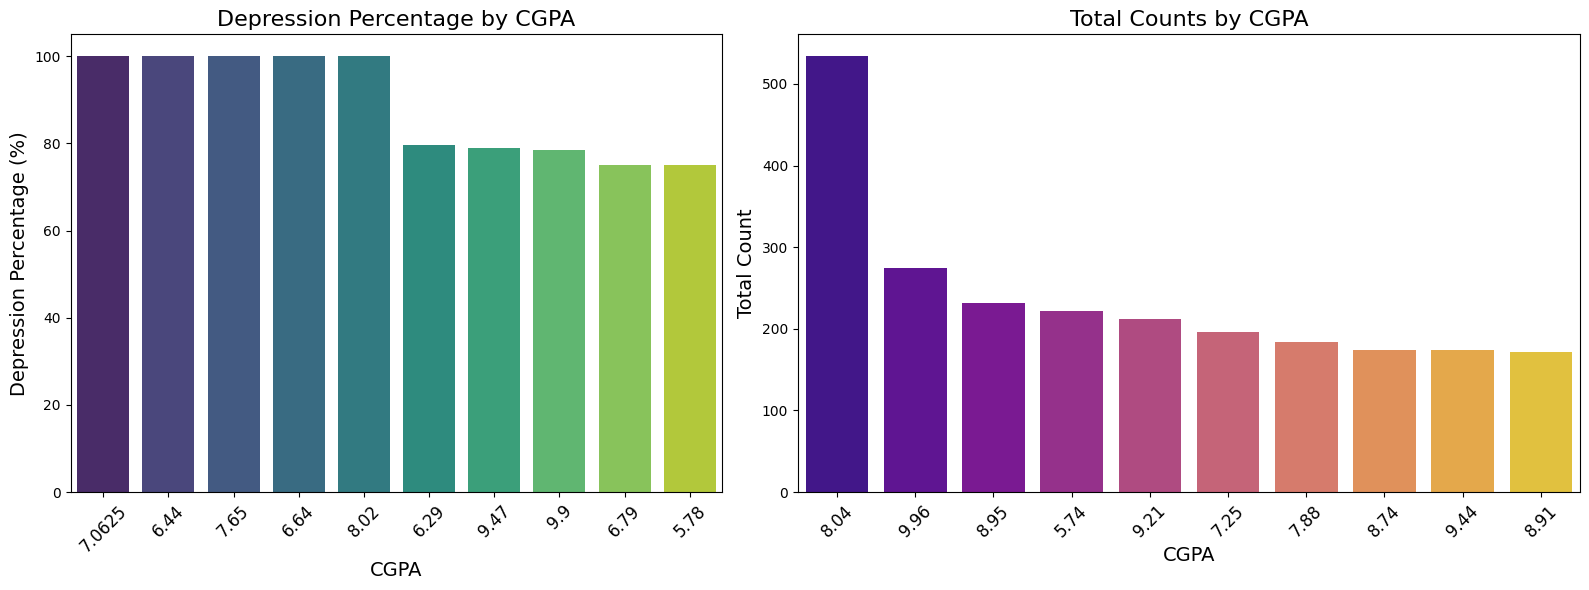

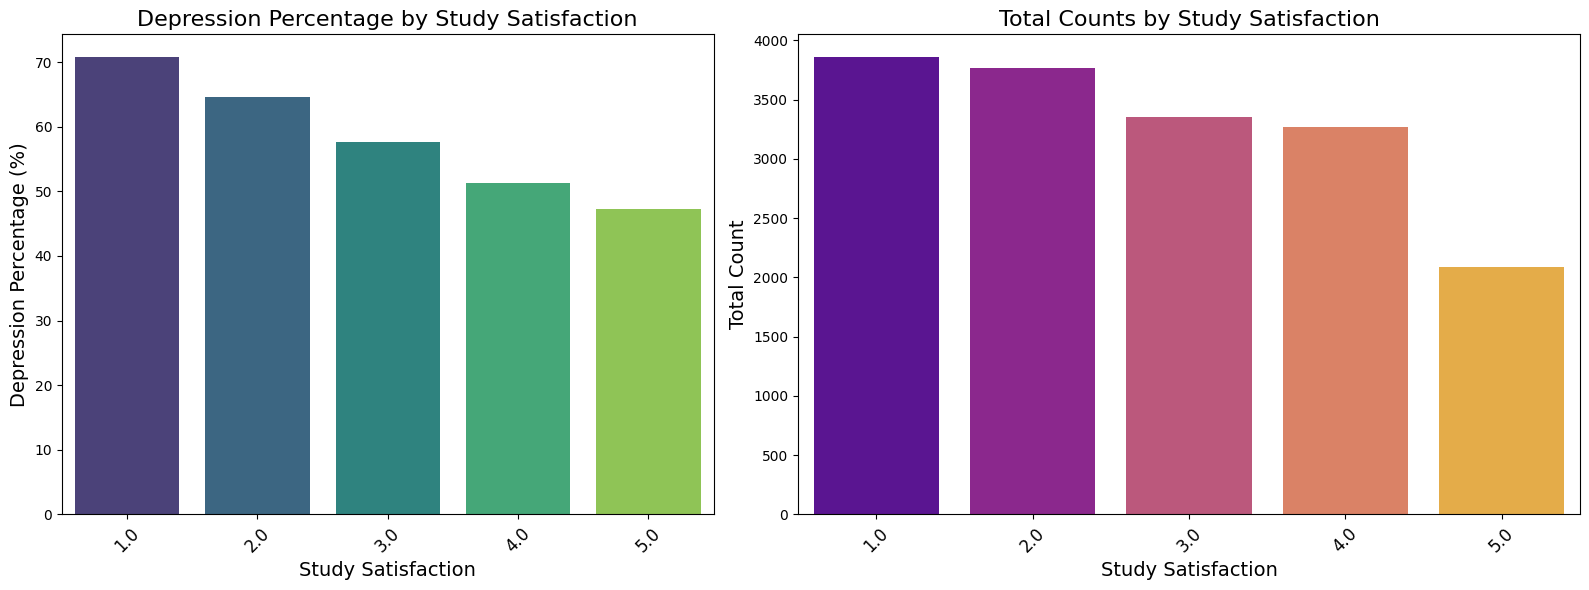

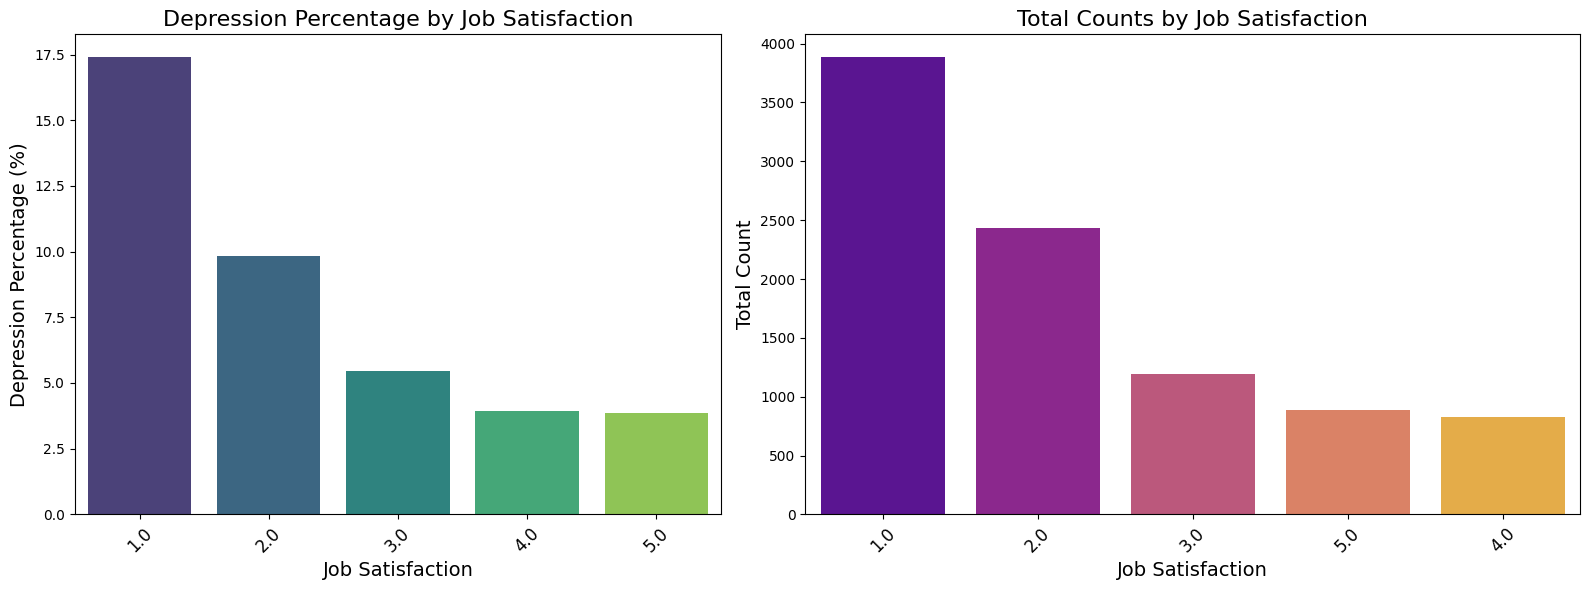

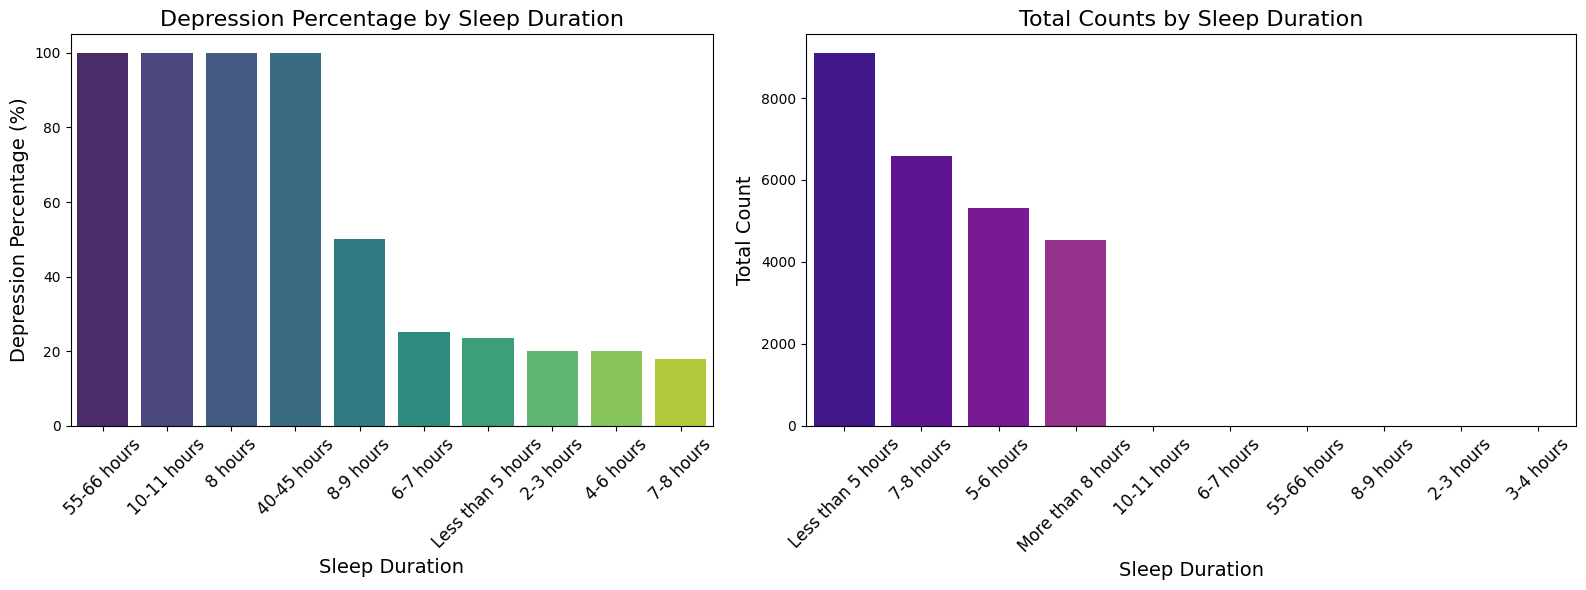

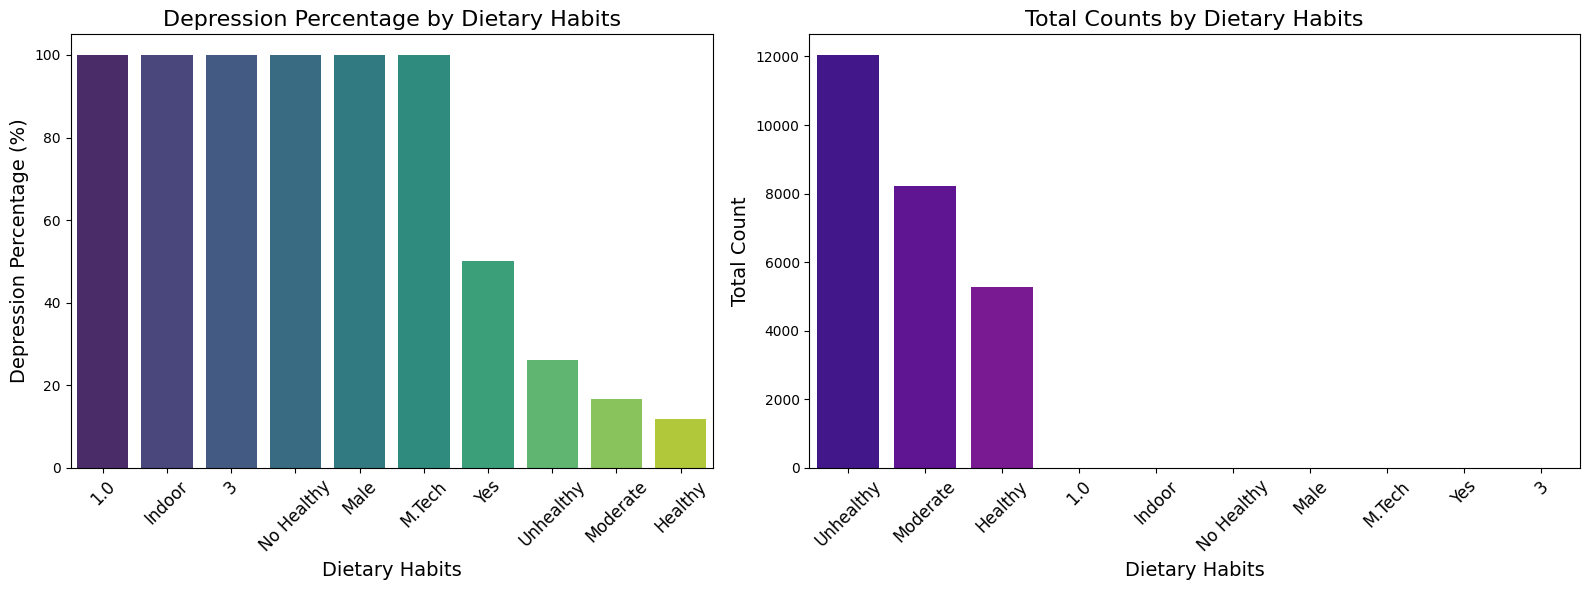

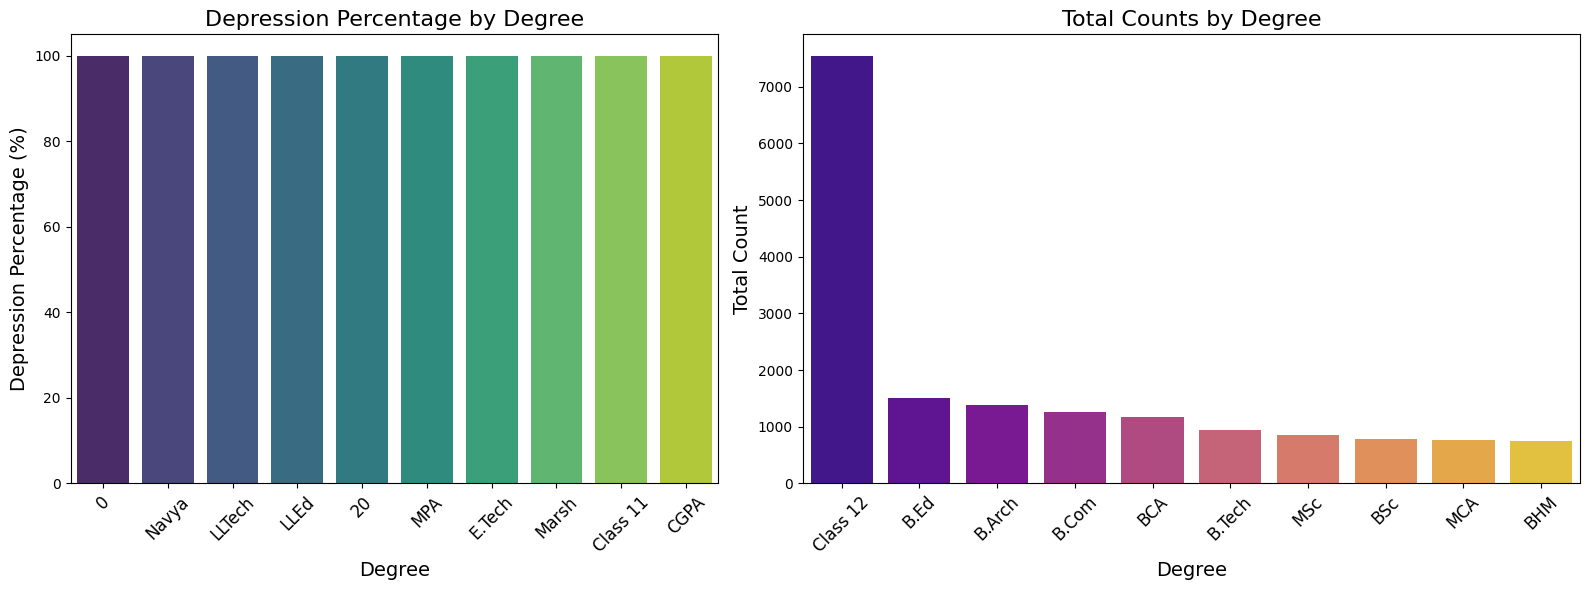

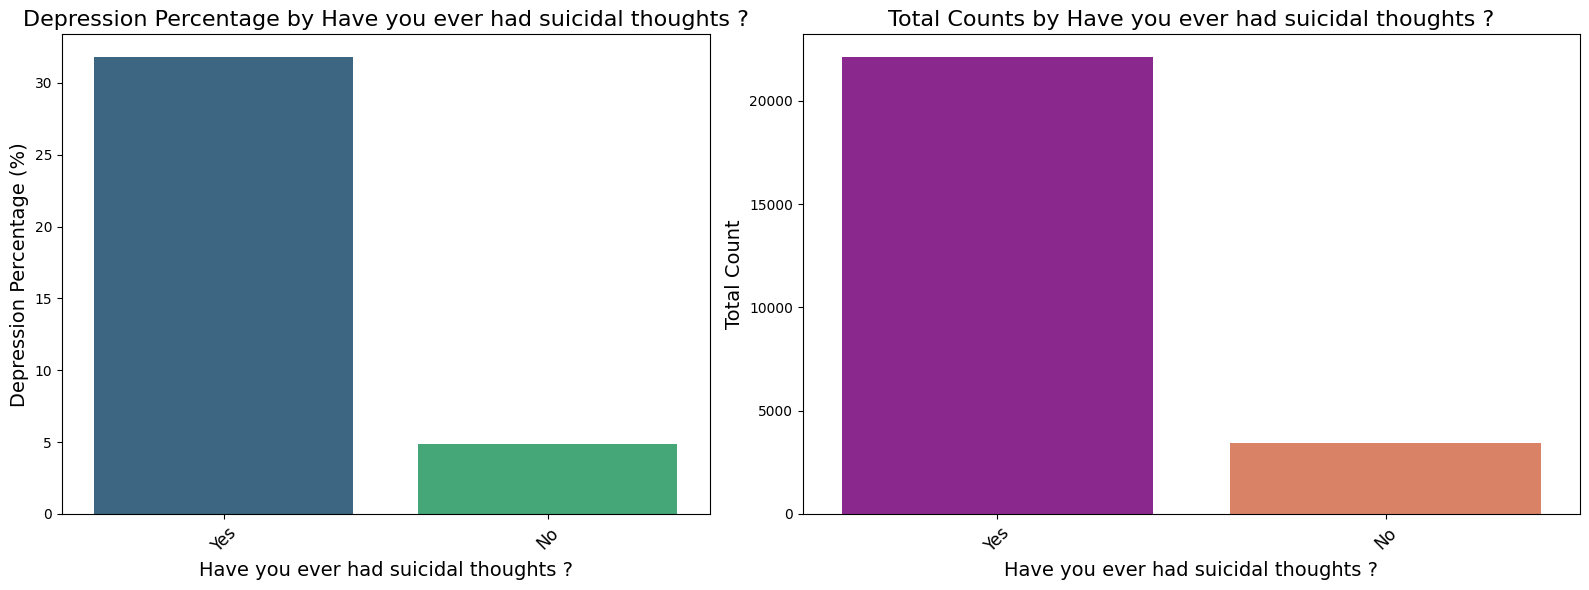

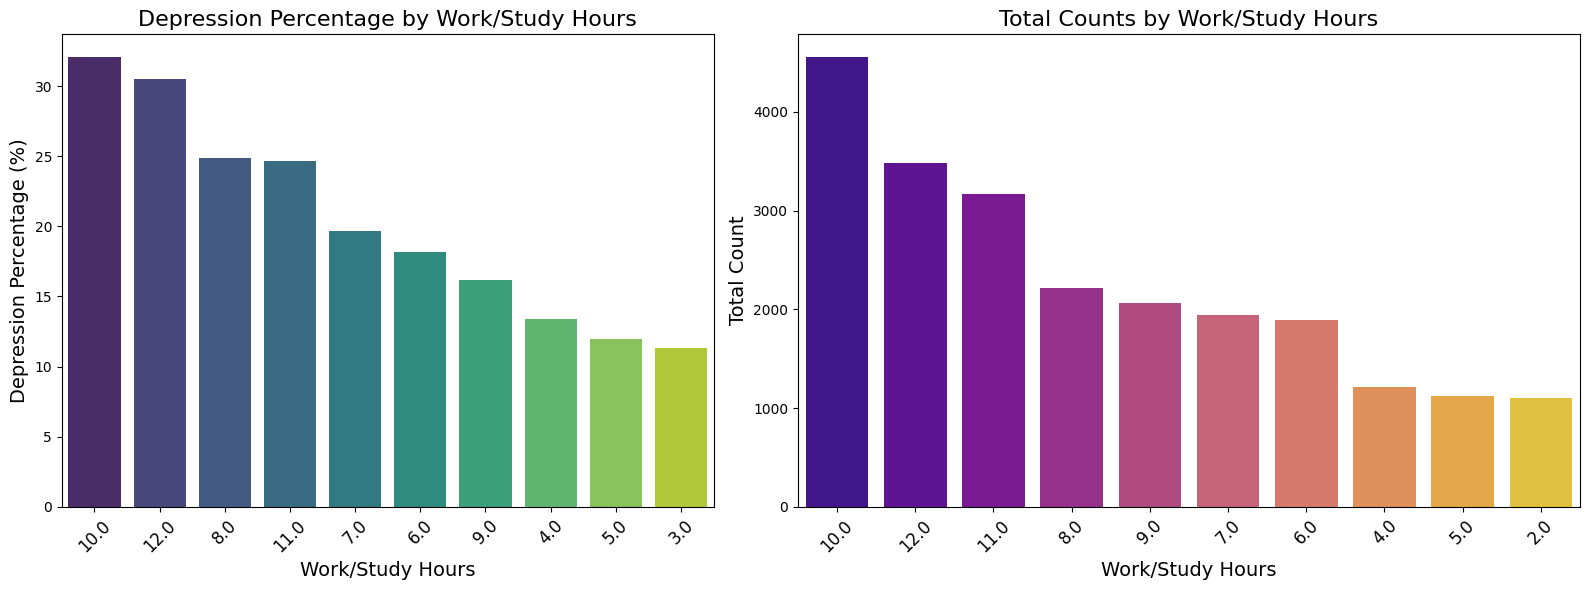

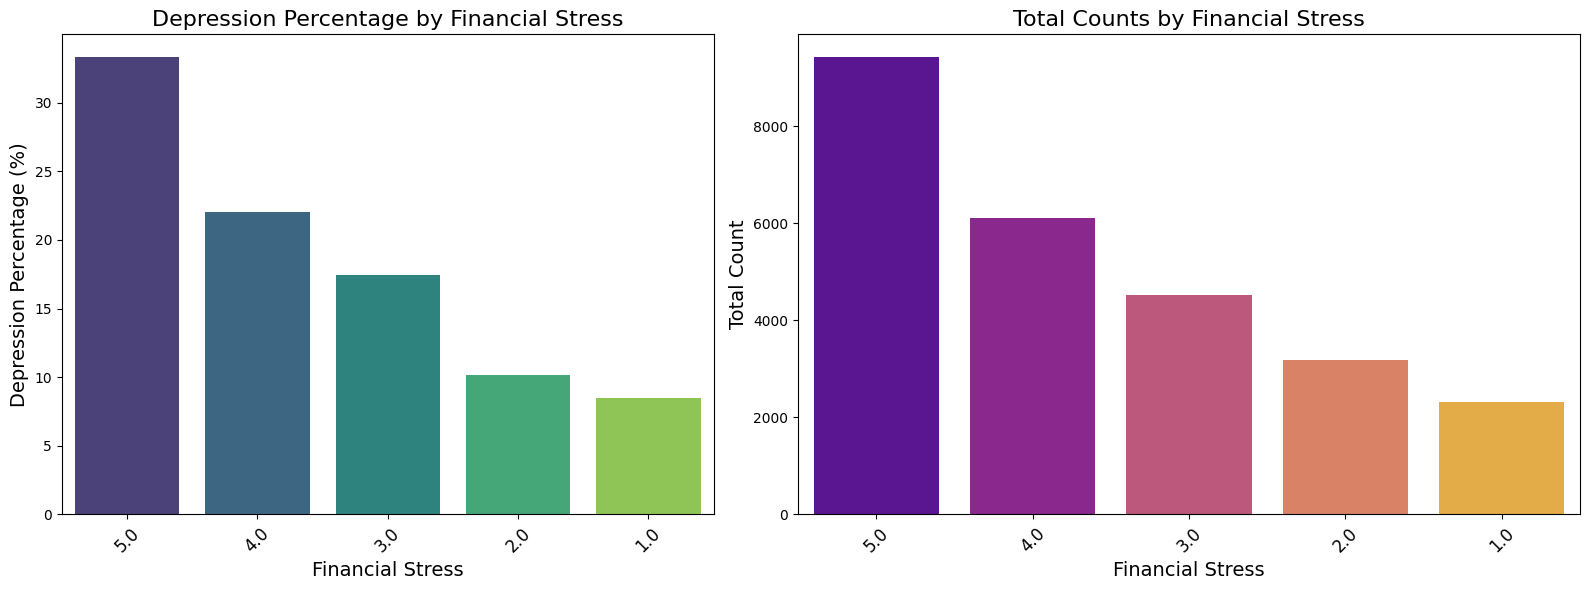

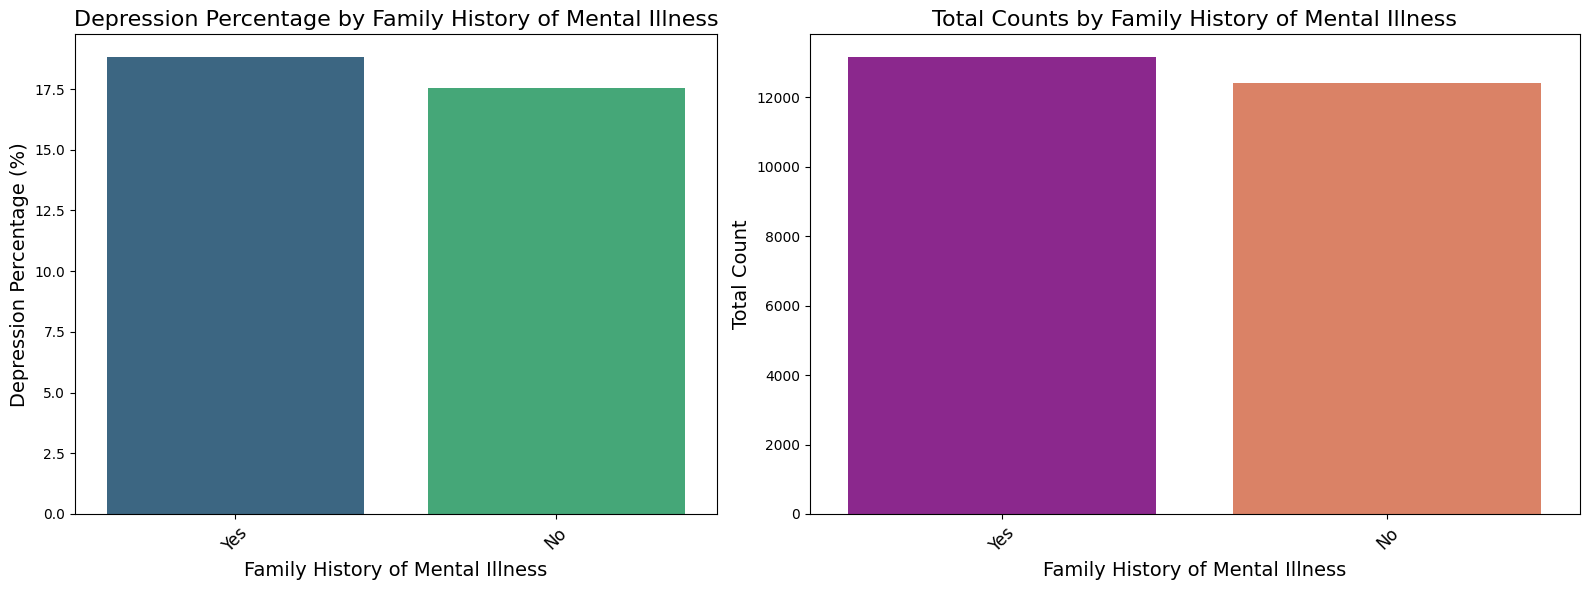

In [52]:
def plot_feature(feature):
    grouped = df.groupby(feature)['Depression']
    percentages = (grouped.sum() / grouped.count() * 100).sort_values(ascending=False).head(10)
    
    groups = df.groupby(col)['Depression'].sum().sort_values(ascending=False).head(10)
    
    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1.2]})
    
    # Bar chart for percentages
    sns.barplot(
        x=percentages.index.astype(str),  # Convert to string to ensure proper ordering
        y=percentages.values,
        palette='viridis',
        ax=axes[0]
    )
    axes[0].set_title(f"Depression Percentage by {feature}", fontsize=16)
    axes[0].set_xlabel(feature, fontsize=14)
    axes[0].set_ylabel("Depression Percentage (%)", fontsize=14)
    axes[0].tick_params(axis='x', rotation=45, labelsize=12)

    # Bar chart for counts
    sns.barplot(
        x=groups.index.astype(str),  # Convert to string to ensure proper ordering
        y=groups.values,
        palette='plasma',
        ax=axes[1]
    )
    axes[1].set_title(f"Total Counts by {feature}", fontsize=16)
    axes[1].set_xlabel(feature, fontsize=14)
    axes[1].set_ylabel("Total Count", fontsize=14)
    axes[1].tick_params(axis='x', rotation=45, labelsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()


for col in df.columns:
    if col not in ['id', 'Name', 'Depression']:
        plot_feature(col)


#### Boosting

In [53]:
# Prepare categorical features
cat_feats = [0, 2, 3, 4, 10, 11, 12, 13, 16]
x.fillna({'Profession': 'none', 'Dietary Habits': 'unknown', 'Degree' : 'none'}, inplace=True)

# display(x)
dataset = Pool(data=x, label=y, cat_features=cat_feats)

cat_model = CatBoostClassifier(verbose=0)

xg_model = XGBClassifier()


xg_model.fit(x_xg, y_xg)
cat_model.fit(dataset)

prediction = cat_model.predict(dataset)
xg_pred = xg_model.predict(x_xg)


accuracy = accuracy_score(y, prediction)
precision = precision_score(y, prediction)
f1 = f1_score(y, prediction)

print('cat',accuracy, precision, f1)


accuracy = accuracy_score(y_xg, xg_pred)
precision = precision_score(y_xg, xg_pred)
f1 = f1_score(y_xg, xg_pred)

print('xg',accuracy, precision, f1)

KeyboardInterrupt: 